# Simulating Gene Expression Dynamics with CausalRegNet

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook")
sns.set_theme(style="whitegrid", palette="tab10", font="Arial")
plt.rcParams['figure.figsize'] = [3, 3]

In [5]:
from causalregnet import sim, fit, utils

## Fitting to Data from Replogle et al. (2022)

In [9]:
# loading cancer gene dataset

# `k562_100_cancer_genes.csv`: expression matrix
# `k562_targets.csv`: intervention target for each row; 'non-targeting' indicates no intervention
# `k562_gene_names.csv`: maps ensembl id's (i.e. alternative gene names) to human readable gene names

df = pd.read_csv('../causalregnet/data/k562_100_cancer_genes.csv', delim_whitespace=True, header=0)
targets = pd.read_csv('../causalregnet/data/k562_targets.csv', delim_whitespace=True, header=None)
targets.columns = ['gene']
gene_names = pd.read_csv('../causalregnet/data/k562_gene_names.csv', delim_whitespace=True, header=0)

# keep observational samples only
df = df.iloc[np.where(targets == 'non-targeting')[0],:]

# selecting first three genes
idx = [0, 1, 2]

# fit negative binomial parameters to each node
mu_nb0, theta_nb0 = fit.fit_nb(data=df.iloc[:,idx[0]])
mu_nb1, theta_nb1 = fit.fit_nb(data=df.iloc[:,idx[1]])
mu_nb2, theta_nb2 = fit.fit_nb(data=df.iloc[:,idx[2]])

## Observational Setting

In [49]:
# CausalRegNet parameters
np.random.seed(0)

mu = np.array([mu_nb0, mu_nb1, mu_nb2])
theta = np.array([theta_nb0, theta_nb1, theta_nb2])
alpha = np.repeat(2, 3)
beta = np.repeat(0.1, 3)
agg_type = 'linear'
reg_constant = np.repeat(1, 3)

B = utils.generate_dag(d=3, m=3)
W = utils.generate_W(B=B, w_ranges=((-2,-0.5), (0.5, 2)))

In [50]:
simulator = sim.Simulator(nnodes=3,
                            mu=mu,
                            theta=theta, 
                            W=W,
                            alpha=alpha,
                            beta=beta,
                            agg_type=agg_type,
                            reg_constant=reg_constant)

simulator.calibrate_sigmoid()

X = simulator.simulate(n_samp=1000)

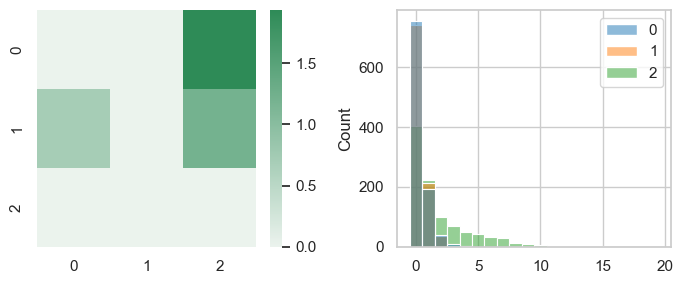

In [57]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)

# strength of relationships 
sns.heatmap(W, cmap=sns.light_palette("seagreen", as_cmap=True), ax=ax[0])
sns.histplot(X, ax=ax[1], bins=np.arange(-0.5, 20.5, step=1))

plt.tight_layout()

## Interventional Setting

In [62]:
X_int = simulator.simulate(n_samp=1000, intervention_type='deterministic', intervention_val=[-1, 0, -1])

In [63]:
X_int

array([[0., 0., 1.],
       [0., 0., 2.],
       [0., 0., 0.],
       ...,
       [1., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.]])

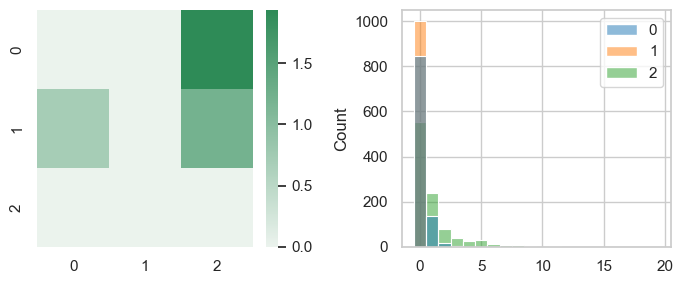

In [64]:
plt.rcParams['figure.figsize'] = [7, 3]
fig, ax = plt.subplots(1, 2)

# strength of relationships 
sns.heatmap(W, cmap=sns.light_palette("seagreen", as_cmap=True), ax=ax[0])
sns.histplot(X_int, ax=ax[1], bins=np.arange(-0.5, 20.5, step=1))

plt.tight_layout()

In [65]:
# average treatment effects
print(X_int.mean(axis=0) - X.mean(axis=0))

[-0.139 -0.31  -0.878]
